In [8]:
import findspark
findspark.init()
import pyspark

from pyspark.sql import SparkSession
from pyspark import SparkConf

from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, VectorIndexer, StringIndexer, Normalizer, StandardScaler, MaxAbsScaler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, TrainValidationSplit
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator


# Algorithms
from pyspark.ml.classification import DecisionTreeClassifier, LinearSVC, RandomForestClassifier


# Others
from collections import OrderedDict

# Graphs libs
import matplotlib.pyplot as plt

# Supress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

# Spark context simple configuration
conf = SparkConf()
conf.setAppName('ipython-notebook').set("spark.driver.memory", "50g")
spark = SparkSession.builder.config(conf=conf).getOrCreate()

spark.version


'2.2.1'

In [9]:
spark.sparkContext.getConf().getAll()

[('spark.driver.memory', '50g'),
 ('spark.driver.host', '10.0.0.36'),
 ('spark.app.id', 'local-1515107628870'),
 ('spark.app.name', 'ipython-notebook'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.driver.port', '39552')]

In [10]:
%load_ext autoreload
%autoreload 2

from Helpers.technical_indicators import calc_ti
from Helpers.generated_features import features_from_OHLC
from Helpers.CustomTS import TrainValidationSplitSorted
from Helpers.best_model_params import *

from ProcessingData.processing import initial_processing, calc_profit, transform_date, train_test_split, complete_processing, simple_processing
from Stats.measures import calc_metrics, best_par
from Helpers.udf import BuyAndHoldClassifier, ReverseTradeClassifier

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
ManualSplit = True
SORT = True
CHUNKS = 6

CV = False

DEBUG = False
RANDOM_SEED = 1

In [12]:
# path_to_csv = "s3://stocksets100/Orlen.csv"
path = "./Datasets/WIG20.csv"
df = complete_processing(spark, path)

train, test = train_test_split(spark, df, CHUNKS, SORT, ManualSplit, RANDOM_SEED)

We have 3318 training examples and 663 test examples. 



In [13]:
# Index labels, adding metadata to the label column.
# Fit on whole dataset to include all labels in index.
featuresCols = df.columns
featuresCols.remove('Profit')
featuresCols.remove('id')
print(featuresCols)

['Open', 'High', 'Volume', 'Low', 'Close', 'MACD', 'CCI', 'OBV', 'RSI']


In [14]:
# Patrameters grid testing
# classifier = DecisionTreeClassifier(
#     labelCol='Profit', featuresCol="features", minInfoGain=0.01,  maxBins=200)

classifier = RandomForestClassifier(
    labelCol='Profit', featuresCol="features", numTrees=25, maxBins=1000)
max_Depth_Range = list(range(2, 15))
min_infoGain = [0.0]
min_InstancesPerNode = [1]
paramGrid = ParamGridBuilder() \
    .addGrid(classifier.maxDepth, max_Depth_Range) \
    .addGrid(classifier.minInfoGain, min_infoGain) \
    .addGrid(classifier.minInstancesPerNode, min_InstancesPerNode).build() \

# classifier = LinearSVC(regParam=0.5, labelCol='Profit', featuresCol="features")
# max_Iter= [10]
# paramGrid = ParamGridBuilder() \
#     .addGrid(classifier.maxIter, max_Iter).build()

# We define an evaluation metric. This tells Validator how well we are doing by comparing the true
# labels with predictions.

evaluator = MulticlassClassificationEvaluator(
    labelCol=classifier.getLabelCol(),
    metricName='accuracy',
    predictionCol=classifier.getPredictionCol())

In [15]:
# Declare the CrossValidator, which runs model tuning for us.
if CV:
    validator = CrossValidator(
        estimator=classifier,
        evaluator=evaluator,
        estimatorParamMaps=paramGrid,
        numFolds=2)
else:
    validator = TrainValidationSplitSorted(
        chunks=CHUNKS,
        spark=spark,
        estimator=classifier,
        estimatorParamMaps=paramGrid,
        evaluator=evaluator)

In [16]:
scaler = None
# scaler = Normalizer(inputCol="features", outputCol="features", p=1.0)
# scaler = StandardScaler(inputCol="rawFeatures", outputCol='features', withMean=True, withStd=True)
# scaler = MaxAbsScaler(inputCol="rawFeatures", outputCol="features")

In [17]:
# Vector Assembler
# This concatenates all feature columns into a single feature vector in a new column "rawFeatures".
# Used for assembling features into a vector.
# We will pass all the columns that we are going to use for the prediction to the VectorAssembler and
# it will create a new vector column.
# Creating Final pipeline object
if scaler is not None:
    vectorAssembler_rt = VectorAssembler(
    inputCols=featuresCols, outputCol="rawFeatures")
    pipeline = Pipeline(stages=[vectorAssembler_rt,scaler, validator])
else:
    vectorAssembler_rt = VectorAssembler(
    inputCols=featuresCols, outputCol="features")
    pipeline = Pipeline(stages=[vectorAssembler_rt, validator])

In [18]:
# FITTING!
pipelineModel = pipeline.fit(train)

# Getting the Best Model
best_classifier = pipelineModel.stages[-1].bestModel

In [19]:
# Feature importance
final_features = best_classifier.featureImportances

feature_dict = {}
for feature, importance in zip(featuresCols, final_features):
    feature_dict[feature] = importance

feature_dict = OrderedDict(sorted(feature_dict.items(), key=lambda t: t[1], reverse=True)) 

i = 1
for feature, importance in feature_dict.items():
    print("{} ; {} ; {}".format(i, feature, round(importance, 3)))
    i+=1

1 ; RSI ; 0.242
2 ; CCI ; 0.177
3 ; OBV ; 0.161
4 ; MACD ; 0.114
5 ; Open ; 0.078
6 ; Close ; 0.062
7 ; High ; 0.06
8 ; Low ; 0.053
9 ; Volume ; 0.052


In [20]:
# Making Predictions!
predictions = pipelineModel.transform(test)

In [21]:
#evaluate results
calc_metrics(predictions)
print(best_par(best_classifier))

Summary Stats
DenseMatrix([[ 282.,   24.],
             [ 323.,   34.]])
accuracy  0.476621417798
sensitivity  0.466115702479
specificity  0.586206896552
precision  0.921568627451
Maximal depth is 2
Minimal info gain is 0.0
Minimal instances per node is 1
(2, 1, 0.0)


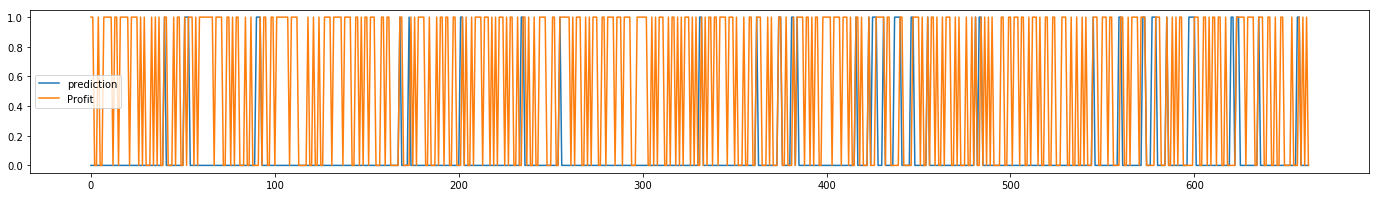

In [22]:
if DEBUG != True:
    df_to_plot_rt = predictions.select('prediction', 'Profit')
    df_to_plot_rt = df_to_plot_rt.toPandas()
    plt.figure(figsize=(24, 3))
    plt.plot(df_to_plot_rt)
    plt.legend(df_to_plot_rt.columns)
    plt.show()

In [29]:
import pandas as pd
i = 0
# path_to_csv = "s3://stocksets100/Orlen.csv"
path = "./Datasets/WIG20Verify.csv"
df = complete_processing(spark, path)
ManualSplit = False
results_MC = []
# pipeline_test = Pipeline(stages=[vectorAssembler_rt,scaler, best_classifier])
pipeline_test = Pipeline(stages=[vectorAssembler_rt, best_classifier])

for i in range(30):
    train, test = train_test_split(spark, df, CHUNKS, SORT, ManualSplit, RANDOM_SEED + i)
    predictions = pipeline_test.fit(test).transform(test)
    results_MC.append(calc_metrics(predictions))
    i+=1

0.45454545454545453,0.4413793103448276,0.6666666666666666,0.9552238805970149
0.4967741935483871,0.5034013605442177,0.375,0.9367088607594937
0.477124183006536,0.4794520547945205,0.42857142857142855,0.9459459459459459
0.49044585987261147,0.4868421052631579,0.6,0.9736842105263158
0.4358974358974359,0.4266666666666667,0.6666666666666666,0.9696969696969697
0.4620253164556962,0.4503311258278146,0.7142857142857143,0.9714285714285714
0.45454545454545453,0.42857142857142855,1.0,1.0
0.4935064935064935,0.48322147651006714,0.8,0.9863013698630136
0.48427672955974843,0.48026315789473684,0.5714285714285714,0.9605263157894737
0.5163398692810458,0.5034013605442177,0.8333333333333334,0.9866666666666667
0.4779874213836478,0.47058823529411764,0.6666666666666666,0.972972972972973
0.4177215189873418,0.4144736842105263,0.5,0.9545454545454546
0.5030674846625767,0.5,0.5714285714285714,0.9629629629629629
0.45569620253164556,0.45454545454545453,0.5,0.9722222222222222
0.4423076923076923,0.43790849673202614,0.6666

In [ ]:
from scipy import stats
k2, p = stats.normaltest(results_MC['accuracy'])
alpha = 5e-3
print(p)
if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")

In [31]:
import pandas as pd
i = 0
avg_accuracy = 0
avg_sensitivity = 0
avg_specificity = 0
avg_precision = 0
path = "./Datasets/WIG20Verify.csv"
df = simple_processing(spark, path)
ManualSplit = False
results_BC = []
retries = 30
for i in range(retries):
    train, test = train_test_split(spark, df, CHUNKS, SORT, ManualSplit, RANDOM_SEED + i)
    results_BC.append(calc_metrics(predictions))
    i+=1
    print("#########################################################################")
    


0.5,0.48717948717948717,1.0,1.0
0.5,0.48717948717948717,1.0,1.0
0.5,0.48717948717948717,1.0,1.0
0.5,0.48717948717948717,1.0,1.0
0.5,0.48717948717948717,1.0,1.0
0.5,0.48717948717948717,1.0,1.0
0.5,0.48717948717948717,1.0,1.0
0.5,0.48717948717948717,1.0,1.0
0.5,0.48717948717948717,1.0,1.0
0.5,0.48717948717948717,1.0,1.0
0.5,0.48717948717948717,1.0,1.0
0.5,0.48717948717948717,1.0,1.0
0.5,0.48717948717948717,1.0,1.0
0.5,0.48717948717948717,1.0,1.0
0.5,0.48717948717948717,1.0,1.0
0.5,0.48717948717948717,1.0,1.0
0.5,0.48717948717948717,1.0,1.0
0.5,0.48717948717948717,1.0,1.0
0.5,0.48717948717948717,1.0,1.0
0.5,0.48717948717948717,1.0,1.0
0.5,0.48717948717948717,1.0,1.0
0.5,0.48717948717948717,1.0,1.0
0.5,0.48717948717948717,1.0,1.0
0.5,0.48717948717948717,1.0,1.0
0.5,0.48717948717948717,1.0,1.0
0.5,0.48717948717948717,1.0,1.0
0.5,0.48717948717948717,1.0,1.0
0.5,0.48717948717948717,1.0,1.0
0.5,0.48717948717948717,1.0,1.0
0.5,0.48717948717948717,1.0,1.0


In [ ]:
from scipy import stats
k2, p = stats.normaltest(results_BC)
alpha = 5e-3
print(p)
if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")

In [ ]:
from scipy import stats
w, p = stats.levene(results_MC,results_BC)
alpha = 5e-3
print(p)
if p < alpha:  # null hypothesis: 
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")
s, p = stats.ttest_ind(results_MC,results_BC,equal_var=True)
alpha = 5e-3
print(p)
if p < alpha:  # null hypothesis: 
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")

In [ ]:
from scipy import stats
# stats_df = pd.DataFrame( {'Accuracy_MC' : results})
stats_df = pd.DataFrame( {'Accuracy_BC' : results_BC ,'Accuracy_MC' : results_MC})
print(stats_df)

In [ ]:
stats_df.plot.box(figsize=(10, 10))
plt.show()